#Language Proficiency Test - ASR Transcriptions
##Tiny

#Step 1: Environment Setup

In [1]:
!pip install -q git+https://github.com/openai/whisper.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.6 MB/s eta 0:00:00


In [2]:
!apt-get update && apt-get install -y ffmpeg

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,683 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,730 kB]
Get:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease [24.6 kB]
Get:13 http://security.ubunt

In [3]:
# Install dependencies
!pip install transformers datasets torchaudio git+https://github.com/openai/whisper.git --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 29.3 MB/s eta 0:00:00


In [5]:
# Step 1: Install dependencies
!pip install -q datasets transformers torchaudio evaluate jiwer matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.9 MB/s eta 0:00:00


# **Step 2: Fine Tunining**

In [7]:
# Step 2: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 3: Define the Google Drive directory
gdrive_output_dir = "/content/drive/MyDrive/NLP_Project/tinymodel/tiny_whisper_model" #for tiny whisper

Mounted at /content/drive


In [8]:
# Step 4: Import packages
from datasets import Dataset, Audio, load_metric
from transformers import (
    WhisperProcessor,
    WhisperForConditionalGeneration,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq
)
import matplotlib.pyplot as plt
import torch
import evaluate
import matplotlib.pyplot as plt
import pandas as pd
from dataclasses import dataclass
from typing import Any, Dict, List, Union

# Load WER metric
wer_metric = load_metric("wer")

<ipython-input-8-fe8598f073f6>:19: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  wer_metric = load_metric("wer")


In [9]:
# Step 5: Accept local CSV dataset (request upload)
from google.colab import files
uploaded = files.upload()  # Upload your CSV with 'audio' (file path) and 'text' columns
csv_file = list(uploaded.keys())[0]

# Step 6: Load dataset using pandas and convert to Hugging Face Dataset
try:
    data = pd.read_csv(csv_file, encoding='latin-1') # Try latin-1 encoding first
except UnicodeDecodeError:
    data = pd.read_csv(csv_file, encoding='cp1252') # If latin-1 fails, try cp1252

dataset = Dataset.from_pandas(data)

Saving newvtwhisperdataset.csv to newvtwhisperdataset.csv


In [10]:
# Step 7: Load and cast audio column
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

In [12]:
# Step 8: Load Whisper model & processor
# it loads the pre-trained Whisper model and its associated processor from Hugging Face's model hub
processor = WhisperProcessor.from_pretrained("openai/whisper-tiny")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny")

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.75k [00:00<?, ?B/s]

In [13]:
# Step 9: Preprocessing function
def preprocess_function(example):
    audio = example["audio"]
    input_features = processor(audio["array"], sampling_rate=16000).input_features[0]
    # Truncate labels to a maximum length (e.g., 128)
    # there was an error due to too-much token, then i handle it by setting max_length==128 and enable truncate
    label_ids = processor.tokenizer(example["text"], max_length=128, truncation=True).input_ids
    return {
        "input_features": input_features,
        "labels": label_ids,
        "text": example["text"], # Keep text for later evaluation if needed
    }

# Step 10: Apply preprocessing
encoded_dataset = dataset.map(preprocess_function)

Map:   0%|          | 0/26 [00:00<?, ? examples/s]

In [14]:
# Step 11: Define custom data collator

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_features": f["input_features"]} for f in features]
        label_features = [{"input_ids": f["labels"]} for f in features]

        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        batch["labels"] = labels
        return batch

data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

In [15]:
# Step 12: Define training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir=gdrive_output_dir,
    per_device_train_batch_size=2,
    num_train_epochs=3,
    logging_steps=10,
    save_steps=50,
    save_total_limit=2,
    report_to=["wandb"],  # Optional: remove if not using Weights & Biases
    predict_with_generate=True,  # Needed for generation-based evaluation
)

In [16]:
#Defining WER computation Function
def compute_wer(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)
    return {"wer": wer}

In [17]:
# Step 13: Define trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset,
    eval_dataset=encoded_dataset,  # Replace with valid eval set if available
    data_collator=data_collator,
    tokenizer=processor.feature_extractor,  # Or processor.tokenizer if applicable
    compute_metrics=compute_wer
)

<ipython-input-17-0a5f8b03c883>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [18]:
# Step 14: Train
trainer.train()
# Step 15: Save the fine-tuned model & processor to Google Drive
model.save_pretrained(gdrive_output_dir)
processor.save_pretrained(gdrive_output_dir)
print(f"Fine-tuned model saved at: {gdrive_output_dir}")

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: serkalem-negusse (serkalem-negusse-fh) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss
10,3.123800
20,1.872700
30,1.376200


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50359, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Fine-tuned model saved at: /content/drive/MyDrive/NLP_Project/tinymodel/tiny_whisper_model


In [20]:
# Step 15: Save the fine-tuned model & processor to Google Drive
model.save_pretrained(gdrive_output_dir)
processor.save_pretrained(gdrive_output_dir)
print(f" Fine-tuned model saved at: {gdrive_output_dir}")

 Fine-tuned model saved at: /content/drive/MyDrive/NLP_Project/tinymodel/tiny_whisper_model


In [21]:
#Step 16: Evaluate WER
results = trainer.evaluate()
print(f"Word Error Rate (WER): {results['eval_wer']:.4f}")

Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Word Error Rate (WER): 1.9482


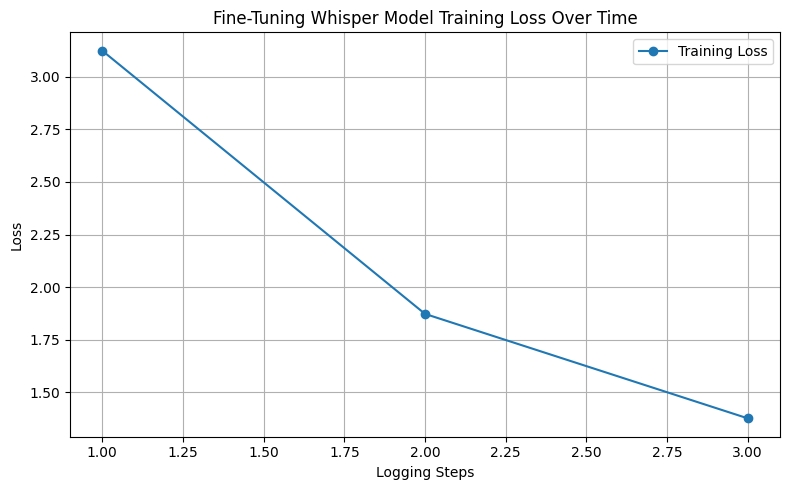

In [22]:
#Step 17: Plot Training Loss
log_history = trainer.state.log_history
losses = [log["loss"] for log in log_history if "loss" in log]
steps = list(range(1, len(losses) + 1))

plt.figure(figsize=(8, 5))
plt.plot(steps, losses, marker="o", label="Training Loss")
plt.xlabel("Logging Steps")
plt.ylabel("Loss")
plt.title("Fine-Tuning Whisper Model Training Loss Over Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#Step